# Forecasting Weekly Data with Prophet

In this notebook we are present an initial exploration of the [Prophet](https://facebook.github.io/prophet/) package by [Facebook](https://opensource.facebook.com/). From the documentation: 

*Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.*^[[https://facebook.github.io/prophet/](https://facebook.github.io/prophet/)]

There is an accompanying paper [Forecasting at scale](https://peerj.com/preprints/3190.pdf) which is quite accessible (of, course the devil is hidden in the details!). In addition, the [Quick Start Guide](https://facebook.github.io/prophet/docs/quick_start.html) is very informative and provides enough information to get a first good impression of the package. There is a R and a Python API. 

## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

**Warning:** At the time of writting this post I enounter a problem when importing `fbprophet`, see the [issue](https://github.com/facebook/prophet/issues/1293) on GitHub. The (partial) solution is given on the thread. The problem as in the structure change of the [`holidays`](https://pypi.org/project/holidays/) package.

## Brief Model Description

The Prophet model has the form $y(t) = g(t) + s(t) + h(t) + \varepsilon_t$, where:

- $g(t)$ is the trend function.
- $s(t)$ is the periodic component (seasonalities)
- $h(t)$ represents holidays/events which occur on potentially irregular basis. 
- $\varepsilon_t$ is the error term (which is often assumed to be normally distributed)

Let us describe these components in more detail:

### Trend:

The basic model for this term is 

$$
g(t) = \frac{C}{1 + e^{-k(t-m)}}
 $$

where $C$ is known as the *capacity*, $k$ the *growth rate* and $m$ the *offset parameter.* Observe that 

$$
\lim_{t\rightarrow \infty} g(t) = C
$$

Let us plot $g(t)$ for various values of $k$.

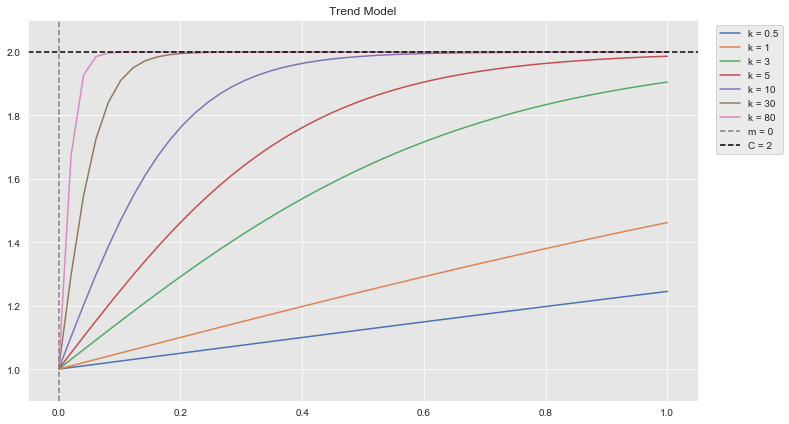

In [2]:
plt.rcParams['figure.figsize'] = [12, 7]

def g(t, k, C=1, m=0):
    """Trend model."""
    return C/(1 + np.exp(-k*(t - m)))

# grid of k values. 
k_grid = [0.5, 1, 3, 5, 10, 30, 80]
# Time range. 
t = np.linspace(start=0, stop=1, num=50)

fig, ax = plt.subplots()

for k in k_grid:
    
    sns.lineplot(
        x=t, 
        y=np.apply_along_axis(lambda t: g(t, k, C=2, m=0), axis=0, arr=t),
        label=f'k = {k}',
        ax=ax
    )

ax.axvline(x=0.0, color='gray', linestyle='--', label='m = 0')
ax.axhline(y=2.0, color='black', linestyle='--', label='C = 2')
ax.legend(bbox_to_anchor=(1.02, 1.0))
ax.set(title='Trend Model', ylim=(0.9, 2.1));

Hence, $C$ and $k$ can be understood as the saturation point.

In the actual implementation, there are some extensions: 

   - The capacity is a function of time $C=C(t)$. 
   - The growth rate is not constant. There is a change-point-grid on which the growth rate is allowed to change. To avoid overfitting, the vector of rate growth adjustments $\bf{\delta}\in \mathbb{R}^{s}$ has a Laplace prior (related to an $L^1$ regularization). For the details please refer to the original paper^[[Forecasting at Scale](https://peerj.com/preprints/3190.pdf)].

### Seasonality 

The seasonal components are approximated by Fourier modes:

$$
s(t) = 
\sum_{n=1}^{N}
\left(
a_n\cos\left(\frac{2\pi nt}{P}\right)
+
b_n\sin\left(\frac{2\pi nt}{P}\right)
\right) 
$$

where $P$ is the period.

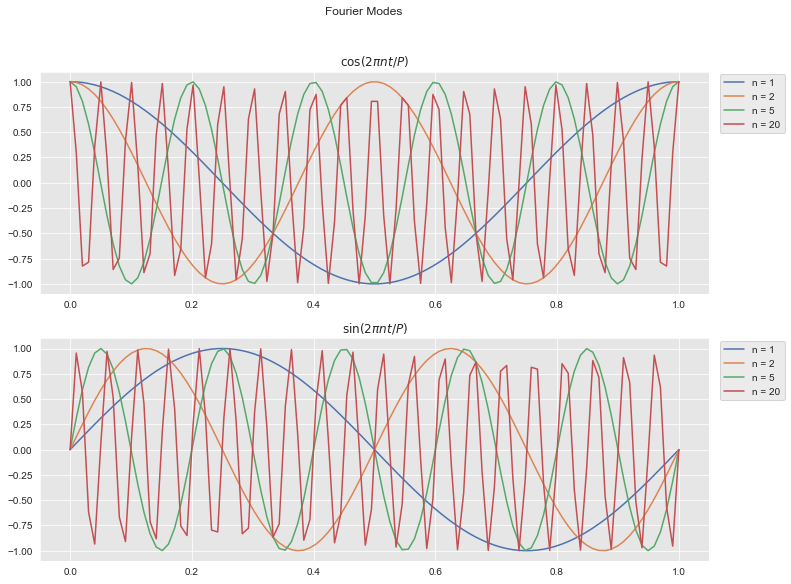

In [3]:
P = 1.0

n_grid = [1, 2 , 5, 20]

t = np.linspace(start=0, stop=P, num=100)

fig, ax = plt.subplots(2, 1, figsize=(12, 9))

for n in n_grid:
    
    sns.lineplot(
        x=t, 
        y=np.apply_along_axis(lambda t: np.cos(2*np.pi*n*t/P), axis=0, arr=t), 
        label=f'n = {n}', 
        ax=ax[0]
    )
    
    sns.lineplot(
        x=t, 
        y=np.apply_along_axis(lambda t: np.sin(2*np.pi*n*t/P), axis=0, arr=t), 
        label=f'n = {n}', 
        ax=ax[1]
    )
    
ax[0].legend(bbox_to_anchor=(1.12, 1.01))
ax[0].set(title=r'$\cos(2\pi n t/P)$')

ax[1].legend(bbox_to_anchor=(1.12, 1.01))
ax[1].set(title=r'$\sin(2\pi n t/P)$')

fig.suptitle('Fourier Modes');

### Holidays and Events

Similar to the seasonal component. 

## Generate Data 

We generate a time series by including the following components:

- We include a non-linear **trend** of the form $\text{trend}(w) = (w + 1)^{2/5} + \log(w + 3)$, where $w$ denotes the week index.

- Seasonality:

    - We use the formula $\sin(2\pi \times \text{day_of_month}/\text{daysinmonth})$ to generate a **monthly seasonality**.  
    - We use the formula $\sin(2\pi \times\text{month}/3) + \cos(2\pi \times \text{month}/4)$ to generate the **yearly  seasonality**. Note that as $3$ and $4$ are relative primes, which implies that the period is the least common multiple $\text{lcm}(3, 4)=12$. 
    - We model the **End of the year season** as a [bump function](https://juanitorduz.github.io/bump_func/). 

- Gaussian Noise

In [4]:
np.random.seed(seed=42)

def generate_time_series_df(start_date, end_date, freq):
    """Generate time series sample data."""
    date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

    df = pd.DataFrame(data={'ds': date_range})
    
    # Get date variables. 
    df['day_of_month'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['daysinmonth'] = df['ds'].dt.daysinmonth
    df['week'] = df['ds'].dt.week
    
    # Time Series Components 
    ## Trend
    df['trend'] = np.power(df.index.values + 1, 2/5) + np.log(df.index.values + 3)
    ## Seasonal
    df['monthly_seas'] = np.cos(2*np.pi*df['day_of_month']/df['daysinmonth'])
    df['yearly_seas'] = 1.2*(np.sin(np.pi*df['month']/3) + np.cos(2*np.pi*df['month']/4))
    df['end_of_year']= - 8.5*np.exp(- ((df['week'] - 51.5)/1.0)**2) \
    ## Gaussian noise
    df['noise'] = np.random.normal(loc=0.0, scale=0.3, size=df.shape[0])
    
    # Target variable.
    df['y'] = df['trend'] \
        + df['monthly_seas'] \
        + df['yearly_seas'] \
        + df['end_of_year'] \
        + df['noise']
    
    return df

df = generate_time_series_df(
    start_date='2016-06-30', 
    end_date='2020-10-31', 
    freq='W'
)

df.head()

,ds,day_of_month,month,daysinmonth,week,trend,monthly_seas,yearly_seas,end_of_year,noise,y
0,2016-07-03,3,7,31,26,2.098612,0.820763,1.03923,-3.384013e-282,0.149014,4.107620
1,2016-07-10,10,7,31,27,2.705802,-0.440394,1.03923,-1.754511e-260,-0.041479,3.263159
2,2016-07-17,17,7,31,28,3.161283,-0.954139,1.03923,-1.231094e-239,0.194307,3.440681
3,2016-07-24,24,7,31,29,3.532861,0.151428,1.03923,-1.169062e-219,0.456909,5.180428
4,2016-07-31,31,7,31,30,3.849564,1.000000,1.03923,-1.502431e-200,-0.070246,5.818549


Let us plot the resulting time series:

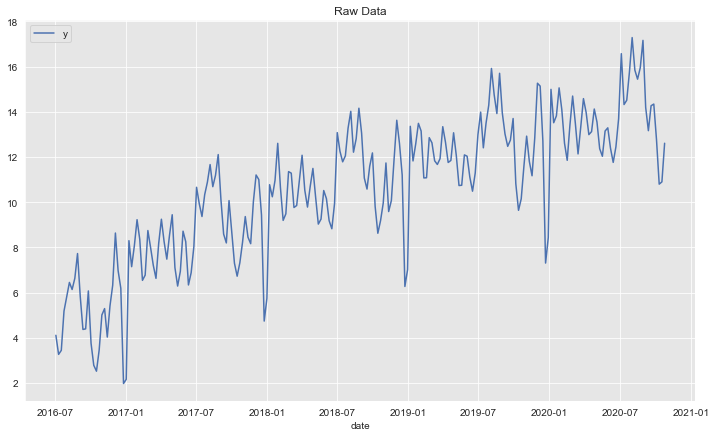

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Raw Data', xlabel='date', ylabel='');

Let us now plot the individual components:

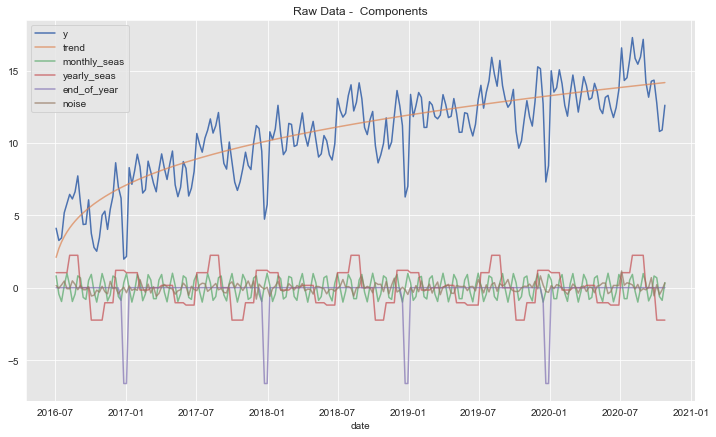

In [6]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y', data=df, ax=ax)
sns.lineplot(x='ds', y='trend', label='trend', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='monthly_seas', label='monthly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='yearly_seas', label='yearly_seas', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='end_of_year', label='end_of_year', data=df, alpha=0.7, ax=ax)
sns.lineplot(x='ds', y='noise', label='noise', data=df, alpha=0.7, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Raw Data -  Components', xlabel='date', ylabel='');

## Training - Test Split

Let us split the data into a training and test set in order to evaluate our model.

In [7]:
# Define threshold date.
threshold_date = pd.to_datetime('2019-11-01')
mask = df['ds'] < threshold_date
# Split the data and select `ds` and `y` columns.
df_train = df[mask][['ds', 'y']]
df_test = df[~ mask][['ds', 'y']]

**Warning:** *The input to Prophet is always a data frame with two columns: `ds` and `y`.*^[[Prophet Docs - Quick Start](https://facebook.github.io/prophet/docs/quick_start.html)]

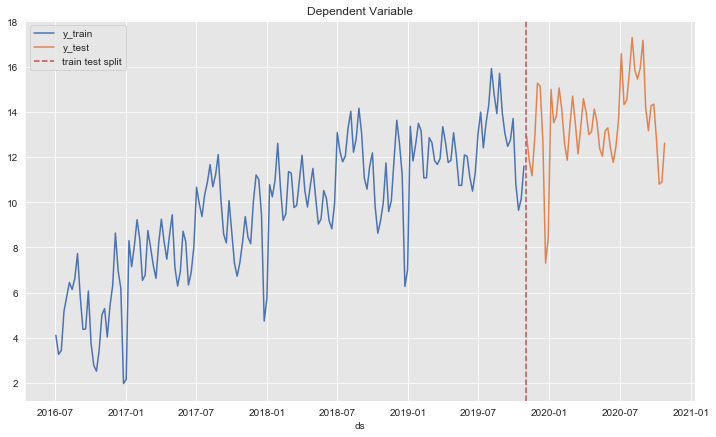

In [8]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

## Time Series Decomposition

We begin the analysis by decomposing the (training) time series into the trend, seasonal and residual components. 

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train.set_index('ds'), 
    model='additive'
)

We plot and compare the results. 

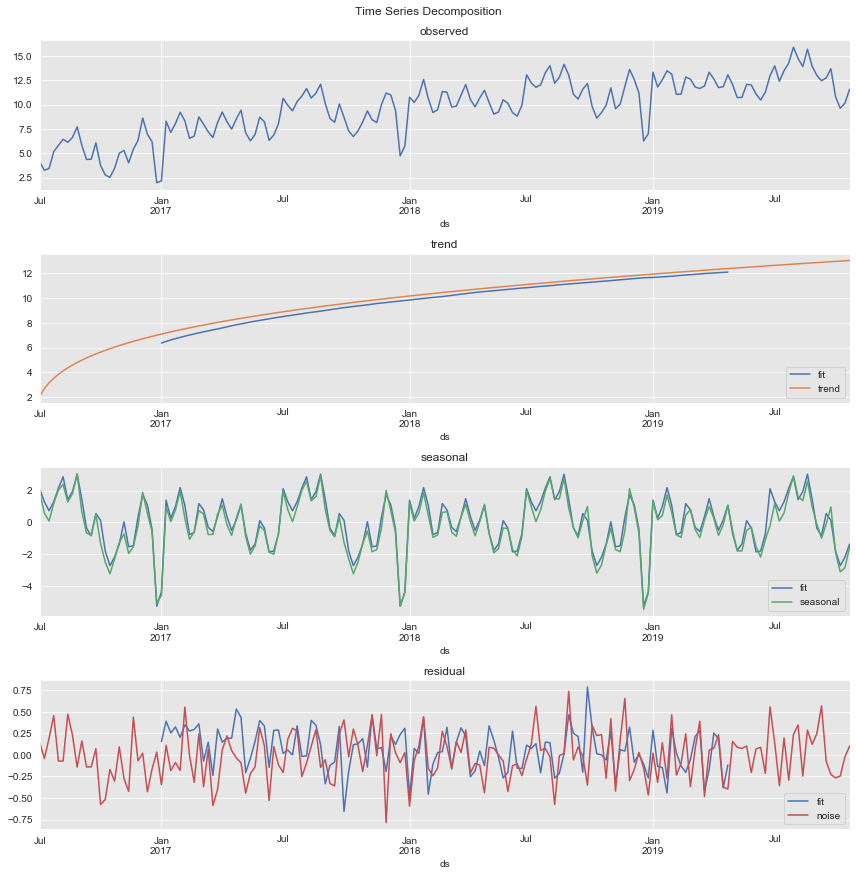

In [10]:
fig, ax = plt.subplots(4, 1, figsize=(12, 12))

# Observed time series.
decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
# Trend component. 
decomposition_obj.trend.plot(label='fit', ax=ax[1])
df[mask][['ds', 'trend']].set_index('ds').plot(c=sns_c[1], ax=ax[1])
ax[1].legend(loc='lower right')
ax[1].set(title='trend')
# Seasonal component. 
decomposition_obj.seasonal.plot(label='fit', ax=ax[2])
df.assign(seasonal = lambda x: x['yearly_seas'] + x['monthly_seas'] + x['end_of_year']) \
    [mask][['ds', 'seasonal']] \
    .set_index('ds')\
    .plot(c=sns_c[2], ax=ax[2])
ax[2].legend(loc='lower right')
ax[2].set(title='seasonal')
# Residual.
decomposition_obj.resid.plot(label='fit', ax=ax[3])
df[mask][['ds', 'noise']].set_index('ds').plot(c=sns_c[3], ax=ax[3])
ax[3].legend(loc='lower right')
ax[3].set(title='residual')

fig.suptitle('Time Series Decomposition', y=1.01)
plt.tight_layout()

**Remarks**:

   - The trend component is overall correct. Nevertheless, it fails to capture it for the initial (non-linear) period. 
   - From the seasonal component obtained we clearly see the yearly and monthly contributions.

## Define Model

Based on the analysis above, we now define the forecasting model structure. 

### Holidays: End of the Year

In most of the resources available, Prophet is applyed to daily data. Here we are interested in the specific case of weekly data. The generalization is pretty straightforward. Nevertheless, There are some important aspects one needs to be particularly careful about. 

According to the documentation^[[Prophet Docs - Modeling Holidays and Special Events](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events)] we can model specific special events by explicitly including them into a `holidays` data frame which must have at least two columns `ds`: date stamp and `holiday`: name of the event. In addition, we can include two columns `lower_window` and `upper_window` which extend the event time stamp to the interval [`ds` - `lower_window`, `ds` + `upper_window`] in days. 

**Warning:** The `holidays` data frame must contain the events in the historical data and also in the future.

To create this data frame for our concrete use case let us get the week date stamps for the end of the year season. 

In [11]:
# End of the year season.
mask_eoy = (df['month']==12) & (df['day_of_month'] > 21)

df[mask_eoy][['ds', 'end_of_year', 'y']]

,ds,end_of_year,y
25,2016-12-25,-6.619807,1.974179
77,2017-12-24,-6.619807,4.736599
78,2017-12-31,-6.619807,5.744007
129,2018-12-23,-6.619807,6.269033
130,2018-12-30,-6.619807,7.014116
181,2019-12-22,-6.619807,7.304637
182,2019-12-29,-6.619807,8.433138


We use these dates to create the `holidays` data frame.

In [12]:
def create_end_of_year_holydays_df():
    """Create holydays data frame for the end of the year season."""
    holidays = pd.DataFrame({
      'holiday': 'end_of_year',
      'ds': pd.to_datetime(
          ['2016-12-25', '2017-12-24', '2018-12-23', '2019-12-22']
      ),
      'lower_window': -7,
      'upper_window': 7,
    })
    return holidays

**Warning:** In a first implementation I just used the 24th of December as the event date stamp. This however did not produce the right result as in the `forecast` below, the `end_of_year` indication function did not appear in the future window. You can see the thread in the [pull request](https://github.com/juanitorduz/website_projects/pull/13) associated to this notebook. This is definitely something to be aware of when working with weekly data in Prophet. 

## Build Model

Now we define the forecasting model object.

In [13]:
def build_model():
    """Define forecasting model."""
    # Create holidays data frame. 
    holidays = create_end_of_year_holydays_df()
    
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False, 
        holidays = holidays, 
        interval_width=0.95, 
        mcmc_samples = 500
    )

    model.add_seasonality(
        name='monthly', 
        period=30.5, 
        fourier_order=5
    )
    
    return model
    
model = build_model()

**Remarks:**

   - We specify to fit the `yearly_seasonality` with the *auto* option for the Fourier modes.
   - We ask for the 0.95 `interval_with` instead of the default (0.8).
   - We include the `mcmc_samples` option to get uncertainty in seasonality (via Bayesian sampling).
   - We add monthly seasonality by specifying the `period` and `fourier_order`. This is the general strategy for adding any type of seasonality.^[[Prophet Docs - Specifying Custom Seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)]

In [14]:
# We train the model with the training data. 
model.fit(df_train)

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



## Generate Predictions

Let us get the model predictions. First we extend the dates from the training data. 

In [15]:
# Extend dates and features. 
future = model.make_future_dataframe(periods=df_test.shape[0], freq='W')
# Generate predictions. 
forecast = model.predict(df=future)

Let us see the columns of the `forecast` data frame.

In [16]:
for c in forecast.columns.sort_values():
    print(c)

additive_terms
additive_terms_lower
additive_terms_upper
ds
end_of_year
end_of_year_lower
end_of_year_upper
holidays
holidays_lower
holidays_upper
monthly
monthly_lower
monthly_upper
multiplicative_terms
multiplicative_terms_lower
multiplicative_terms_upper
trend
trend_lower
trend_upper
yearly
yearly_lower
yearly_upper
yhat
yhat_lower
yhat_upper


- The variable `yhat` represents the model predictions.
- For all the components we have the `_lower` and `_upper` bounds.

Let us verify the encoding of the `end_of_year` season in the `forecast` data frame.

In [17]:
forecast[forecast['end_of_year'].abs()>0][['ds', 'end_of_year']]

,ds,end_of_year
24,2016-12-18,-1.767771
25,2016-12-25,-7.380399
26,2017-01-01,-6.862743
76,2017-12-17,-1.767771
77,2017-12-24,-7.380399
78,2017-12-31,-6.862743
128,2018-12-16,-1.767771
129,2018-12-23,-7.380399
130,2018-12-30,-6.862743
180,2019-12-15,-1.767771


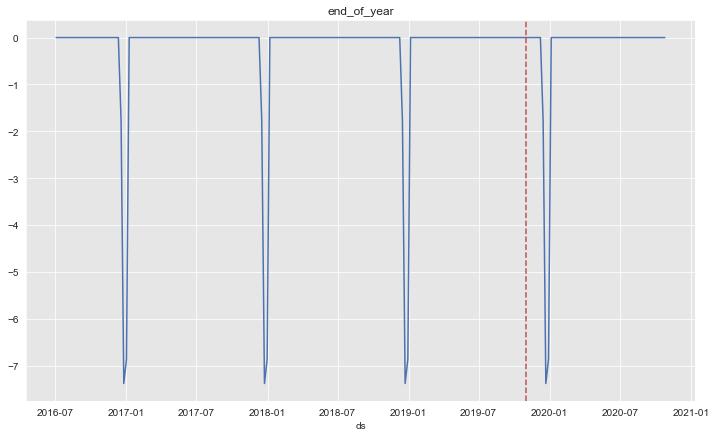

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x='ds', y='end_of_year', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.set(title='end_of_year', ylabel='');

The seasonality works as expected (see **Warning** above).

Let us split the predictions into training and test set. 

In [19]:
mask2 = forecast['ds'] < threshold_date

forecast_train = forecast[mask2]
forecast_test = forecast[~ mask2]

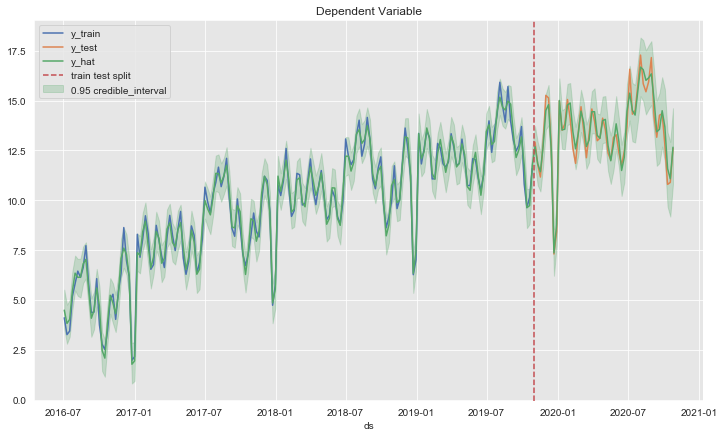

In [20]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['yhat_lower'],
    y2=forecast['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='');

Zooming in:

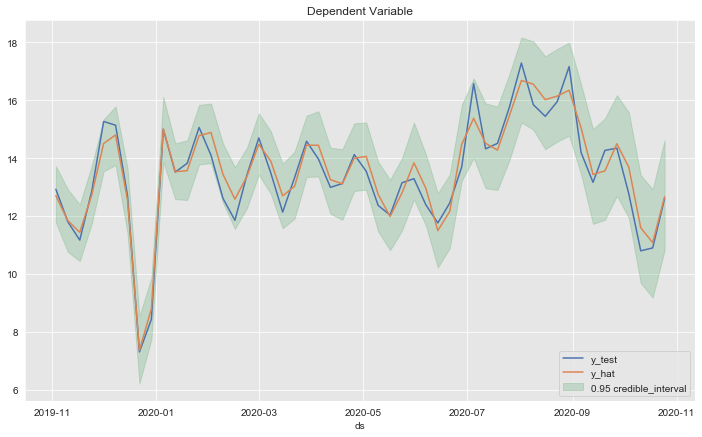

In [21]:
fig, ax = plt.subplots()

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.legend(loc='lower right')
ax.set(title='Dependent Variable', ylabel='');

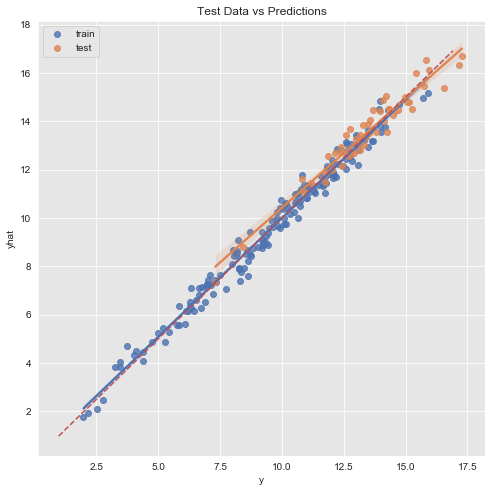

In [22]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_train['y'].min() - 1, stop=df_train['y'].max() + 1, num=100)

sns.regplot(x=df_train['y'], y=forecast_train['yhat'], color=sns_c[0], label='train', ax=ax)
sns.regplot(x=df_test['y'], y=forecast_test['yhat'], color=sns_c[1], label='test', ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, color=sns_c[3], ax=ax)
ax.lines[2].set_linestyle('--')
ax.set(title='Test Data vs Predictions');

Let us compute the `r2_score` and `mean_absolute_error` on the training and test set respectively: 

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error

print('r2 train: {}'.format(r2_score(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('r2 test: {}'.format(r2_score(y_true=df_test['y'], y_pred=forecast_test['yhat'])))
print('---'*10)
print('mae train: {}'.format(mean_absolute_error(y_true=df_train['y'], y_pred=forecast_train['yhat'])))
print('mae test: {}'.format(mean_absolute_error(y_true=df_test['y'], y_pred=forecast_test['yhat'])))

r2 train: 0.9830369776415686
r2 test: 0.9320449074303058
------------------------------
mae train: 0.3113940440897326
mae test: 0.38975341010250913


This might indicate a potential overfit. In a second iteration one could modify the `prior_scale` in the model definition to add more regularization.^[[Prophet Docs - Prior Scale for Holidays and Seasonality](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#prior-scale-for-holidays-and-seasonality)]

## Error Analysis

Let us study the forecast errors. 

- Distribution

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



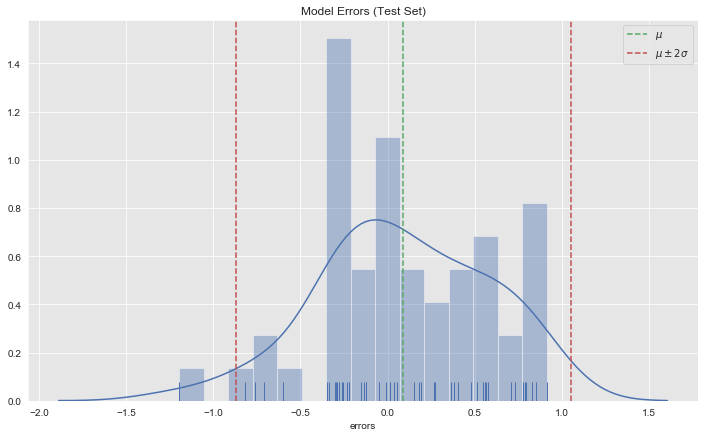

In [24]:
forecast_test.loc[:, 'errors'] = forecast_test.loc[:, 'yhat'] - df_test.loc[:, 'y']

errors_mean = forecast_test['errors'].mean()
errors_std = forecast_test['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=forecast_test['errors'], ax=ax, bins=15, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

- Autocorrelation 

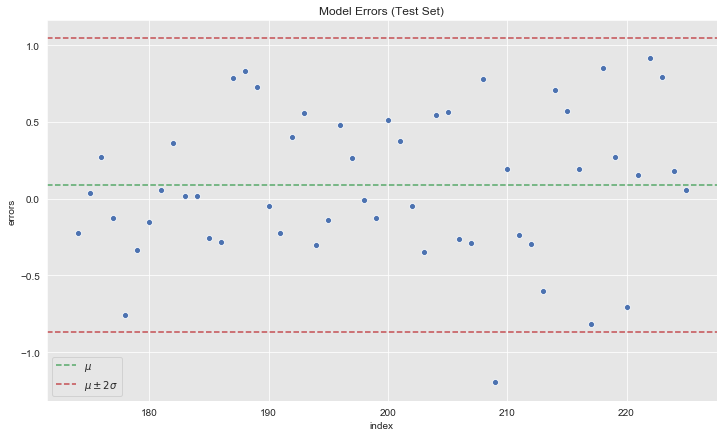

In [25]:
fig, ax = plt.subplots()

sns.scatterplot(x='index', y='errors', data=forecast_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');

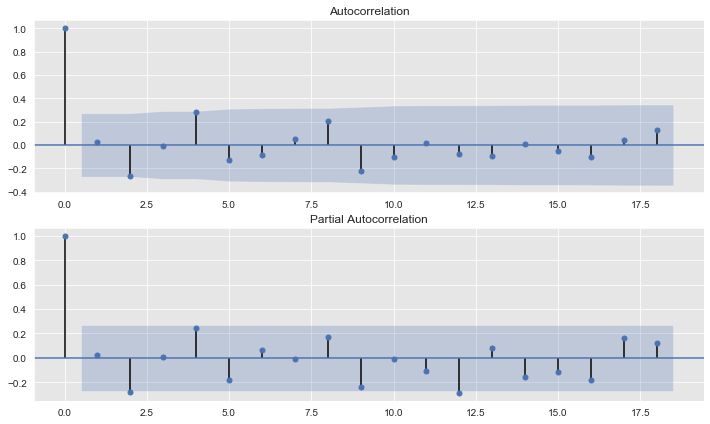

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1)
plot_acf(x=forecast_test['errors'], ax=ax[0])
plot_pacf(x=forecast_test['errors'], ax=ax[1]);

## Model Deep Dive

- Model Components

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



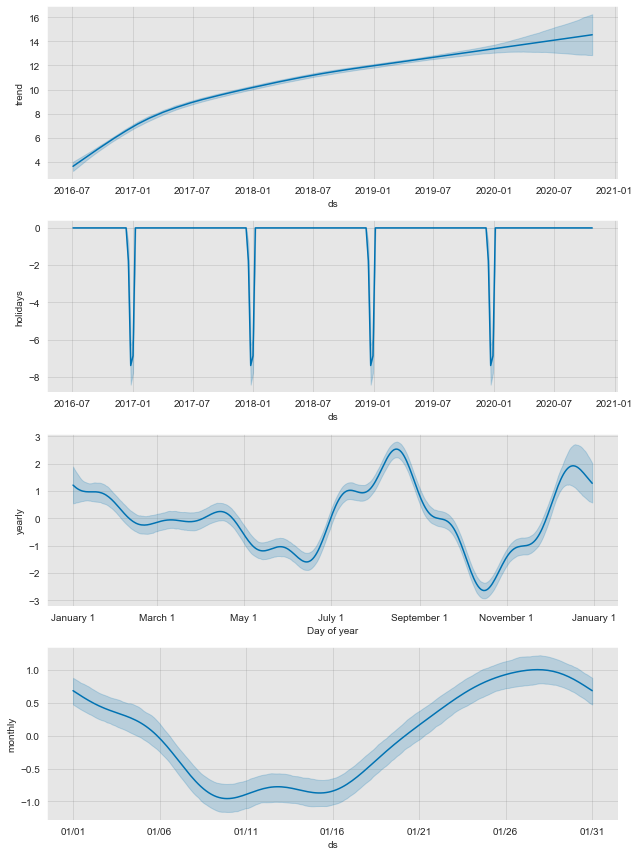

In [27]:
# Plot model components.
fig = model.plot_components(forecast)

- Trend Fit 

Let us plot where 

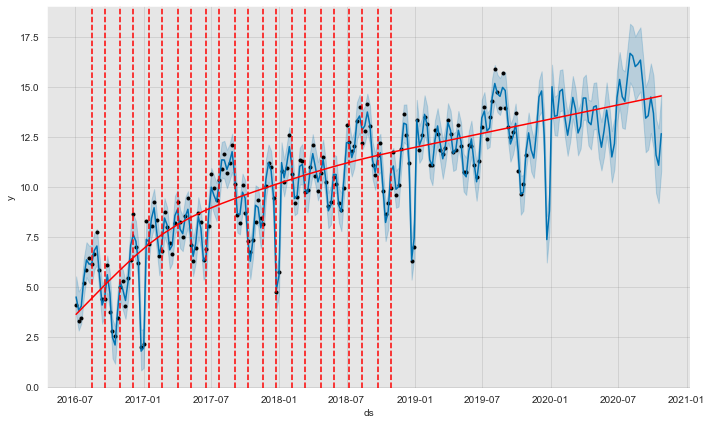

In [28]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

Let us compare the true and the fitted trend:

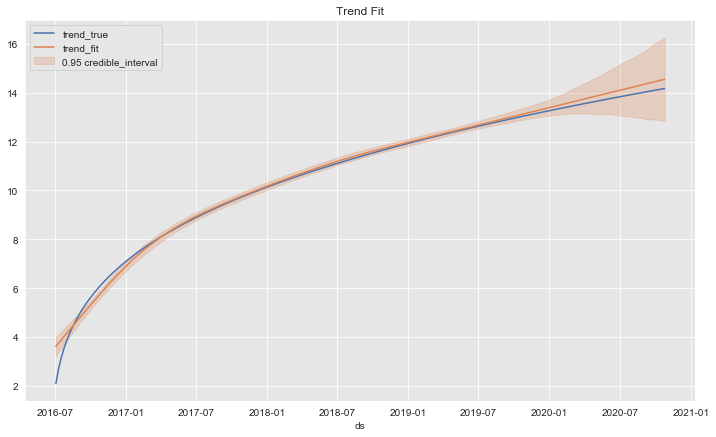

In [29]:
fig, ax = plt.subplots()

sns.lineplot(x='ds', y='trend', data=df, label='trend_true', ax=ax)

ax.fill_between(
    x=forecast['ds'],
    y1=forecast['trend_lower'],
    y2=forecast['trend_upper'],
    color=sns_c[1], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='trend', data=forecast, label='trend_fit', ax=ax)
ax.legend(loc='upper left')
ax.set(title='Trend Fit', ylabel='');

The trend fit is quite good. 

## Diagnostics - Timeslice Cross-Validation

The `cross_validation` function from the `fbprophet.diagnostics` module allow us to run a timeslice cross-validation on the model by specifying^[[Prophet Docs - Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)]:

   - `initial`: initial training period.
   - `period`: spacing between cutoff dates.
   - `horizon`: forecast horizon on each cross-validation step. 
   
From the documentation:

*The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between `cutoff` and `cutoff + horizon`. This dataframe can then be used to compute error measures of yhat vs. y.*^[[Prophet Docs - Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html)]

In [30]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(
    model=model, 
    initial='730 days', 
    period='35 days', 
    horizon = '56 days'
)

df_cv.head()

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-07-08 00:00:00 and 2019-09-01 00:00:00
/Users/juanitorduz/opt/anaconda3/envs/website_projects/lib/python3.7/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-07-15,11.277463,10.113520,12.338289,11.784229,2018-07-08
1,2018-07-22,11.559885,10.260493,12.750059,12.048262,2018-07-08
2,2018-07-29,13.233127,12.005542,14.549008,13.275847,2018-07-08
3,2018-08-05,13.433929,12.215635,14.669104,14.019124,2018-07-08
4,2018-08-12,13.037136,11.860215,14.280776,12.210764,2018-07-08


**Remark:** For weekly data it might be convenient to choose `horizon` as a multiple of $7$ to have the same number of observations on each week of the horizon.

It is then easy to compute some error metrics via the ` performance_metrics` function. 

**Remark:** The metric computations are done on a rolling window specified by the `rolling_window` parameter. There is a clear explanation of it on the funtion doc-strings:

- *Metrics are calculated over a rolling window of cross validation predictions, after sorting by horizon. Averaging is first done within each value of horizon, and then across horizons as needed to reach the window size. The size of that window (number of simulated forecast points) is determined by the rolling_window argument, which specifies a proportion of simulated forecast points to include in each window. rolling_window=0 will compute it separately for each horizon. The default of `rolling_window`=0.1 will use 10% of the rows in df in each window. `rolling_window`=1 will compute the metric across all simulated forecast points. The results are set to the right edge of the window*^[[https://github.com/facebook/prophet/blob/master/python/fbprophet/diagnostics.py](https://github.com/facebook/prophet/blob/master/python/fbprophet/diagnostics.py)].

In [31]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(df=df_cv, rolling_window=0.1)

df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,7 days,0.257659,0.507601,0.426332,0.035046,0.923077
1,14 days,0.178867,0.422926,0.349699,0.028023,1.000000
2,21 days,0.134741,0.367070,0.313919,0.026665,1.000000
3,28 days,0.218242,0.467164,0.414246,0.036193,1.000000
4,35 days,0.373152,0.610862,0.457132,0.044546,0.846154


Let us see the how to compute the `mae` for the case `rolling_window` = 0.0

In [32]:
df_p = performance_metrics(df=df_cv, rolling_window=0.0)

df_p.head()

,horizon,mse,rmse,mae,mape,coverage
0,7 days,0.257659,0.507601,0.426332,0.035046,0.923077
1,14 days,0.178867,0.422926,0.349699,0.028023,1.000000
2,21 days,0.134741,0.367070,0.313919,0.026665,1.000000
3,28 days,0.218242,0.467164,0.414246,0.036193,1.000000
4,35 days,0.373152,0.610862,0.457132,0.044546,0.846154


We can get the `mae` column explicitly as:

In [33]:
df_cv.assign(abs_error = lambda x: (x['y'] - x['yhat']).abs()) \
    .assign(horizon = lambda x: x['ds'] - x['cutoff']) \
    .assign(horizon = lambda x: x['horizon']) \
    .groupby('horizon', as_index=False) \
    .agg({'abs_error': np.mean}) \
    .rename(columns={'abs_error': 'mae'})

,horizon,mae
0,7 days,0.426332
1,14 days,0.349699
2,21 days,0.313919
3,28 days,0.414246
4,35 days,0.457132
5,42 days,0.397166
6,49 days,0.353108
7,56 days,0.309288


We can plot these metrics as a function of the `horizon` parameter. 

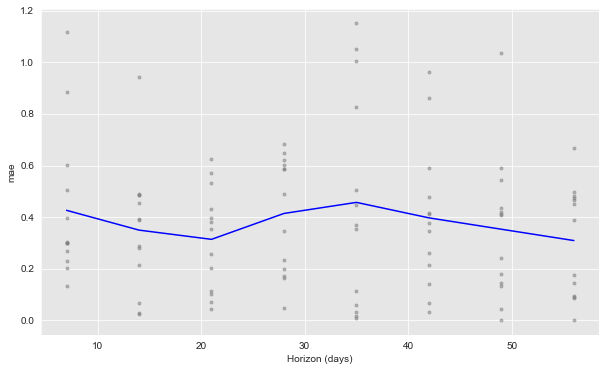

In [34]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(df_cv=df_cv, metric='mae', rolling_window=0.1)

Prophet makes the timeslice cross-validation metric computation procedure quite straightforward. 

---
I strongly recommend going to [Prophet Documentation](https://facebook.github.io/prophet/docs/quick_start.html) and the [source code](https://github.com/facebook/prophet) to keep learning abut this forecasting framework (I definitely will!). Moreover, the [notebook](https://nbviewer.jupyter.org/github/nicolasfauchereau/Auckland_Cycling/blob/master/notebooks/Auckland_cycling_and_weather.ipynb) shows a concrete use case when external regressors are added to the model. Finally, I want to point out an [article](https://databricks.com/blog/2020/01/27/time-series-forecasting-prophet-spark.html) on how to scale this via [Spark](https://spark.apache.org/).